In [1]:
cd /home/ubuntu/DistMEC/

/home/ubuntu/DistMEC


In [2]:
import sqlite3
import pandas as pd
import numpy as np
import math
import copy
import pickle

from classes.User import *
from classes.solver import *
from classes.Server import *
from classes.distributed_utils import *


In [3]:
def longlat2km(lat1, long1, lat2, long2):
    D = 40075 # km
    dy = (lat1-lat2) * 111.32
    dx = (long1 - long2)*(D * np.cos((lat1+lat2)/(2 * 180 )))/(360)
    
    return dy, dx

def load_usr(db, ts_min_size = 5):
    cnx = sqlite3.connect(db)
    df = pd.read_sql_query("SELECT * FROM locationTable", cnx)

    cnx.close()

    df = df[df['_activity'] == 2]
    df = df[df['_latitude']>0]
    df = df[df['_longitude']>0]
    
    times = np.array(df['_time_location'])
    date_list = []
    hr_list = []
    min_list = []
    ts_list = []
    

    for t in times:
        date_list+= [t[4:-9]]
        hr_list+= [int(t[8:-7])]
        min_list += [int(t[10:-5])]
        ts_list += [np.round((hr_list[-1]*60 + min_list[-1])/ts_min_size)]
        
    df['Date'] = date_list
    df['Hr'] = hr_list
    df['Min'] = min_list
    df['ts'] = ts_list

    
    lat = np.array(df['_latitude']*10e-7)
    long = np.array(df['_longitude']*10e-7)

    mean_lat = np.mean(lat)
    mean_long =  np.mean(long)

    dx,dy = longlat2km(lat,long,mean_lat,mean_long)

    df['x_loc'] = dx/1.6
    df['y_loc']= dy/1.6 # Change to miles

    df_copy = df
    
    df = df.drop(['_node_id','_latitude_gps','_longitude_gps','_latitude_wifi','_longitude_wifi',
             '_altitude','_accuracy','_accuracy_gps','_accuracy_wifi','_place_name','_place_comment',
                 '_latitude','_longitude','_activity','_time_location'], axis=1)

    
    traces = {}
    
    for date in date_list:
        temp_df = np.array(df[df["Date"]==date])[:,3:]
        
        # Normalize X and Y here to be average for that date (mean = 0)
        ts = temp_df[:,0]
        x = temp_df[:,1] # - np.mean(np.unique(temp_df[:,1]))
        y = temp_df[:,2] # - np.mean(np.unique(temp_df[:,2]))
        
        temp_df[:,1] = x
        temp_df[:,2] = y
        
        temp_final = np.empty([0,3])
        temp_final = np.append(temp_final,np.reshape(temp_df[0],[1,3]),axis=0)
                
        for i in range(ts.shape[0]-1):
            t2 = int(ts[i+1])
            t1 = int(ts[i])
            
            row_2 = temp_df[i+1,:]
            row_1 = temp_df[i,:]
            
            t_diff = t2 - t1
            
            # Extrapolate
            if t_diff > 1:
                times = range(t1+1,t2+1)
                del_x = x[i+1]-x[i]
                del_y = y[i+1]-y[i]
                
                ratio_count = 1
                
                for t in times:
                    temp_x = x[i] + (ratio_count/t_diff) * del_x
                    temp_y = y[i] + (ratio_count/t_diff) * del_y
                    
                    temp = np.array([[t,temp_x,temp_y]])
                    temp_final = np.append(temp_final,temp,axis=0)
                    
                    ratio_count += 1
                
            # Delete one of the cases    
            elif t_diff == 0:
                continue
                
            # Proceed as normal    
            elif t_diff == 1:
                temp_final = np.append(temp_final,np.reshape(row_2,[1,3]),axis=0)
            
        traces[date] = temp_final
    
    return df, traces #, df_copy


In [4]:
# a,b,c = load_usr("LifeMap_GS1.db")

In [5]:
# min(c["_longitude"])*10e-7

In [6]:
# max(a['x_loc'])

In [7]:
db_start = "crawdad_mobility/LifeMap_GS"
df = {}
traces = {}

for i in range(1,13):
    print("round", i)
    db = db_start + str(i) + ".db"
    df[i], traces[i] = load_usr(db)

round 1
round 2
round 3
round 4
round 5
round 6
round 7
round 8
round 9
round 10
round 11
round 12


In [31]:
# Combine all time steps into one long run
traces_combined = {}

for i in range(1,13):
    key = list(traces[i])[0]
    size = traces[i][key].shape[1]
    
    temp = np.empty([0,size])
    
    for k in traces[i].keys():
        temp = np.append(temp, traces[i][k],axis=0)
        
    traces_combined[i] = temp

In [32]:
# Normalize movement
for i in range(1,13):
    temp = traces_combined[i]
    print(i, "x_min:", min(temp[1]), "x_max:", max(temp[1]), "y_min:", min(temp[2]), "y_max:", max(temp[2]))

1 x_min: -7.836966219229323 x_max: 139.0 y_min: -7.6697193733674585 y_max: 140.0
2 x_min: -12.386985776665616 x_max: 116.0 y_min: -12.386985776665616 y_max: 117.0
3 x_min: -10.189351274697566 x_max: 180.0 y_min: -10.189181113883114 y_max: 181.0
4 x_min: -2.4118381801867588 x_max: 91.0 y_min: -2.382313824304387 y_max: 92.0
5 x_min: -32.75479072651423 x_max: 146.0 y_min: -32.73560976205753 y_max: 147.0
6 x_min: 1.780992654644033 x_max: 100.0 y_min: 1.666976229622524 y_max: 159.0
7 x_min: -14.33946071515848 x_max: 188.0 y_min: -14.33946071515848 y_max: 189.0
8 x_min: -5.223098499249298 x_max: 225.0 y_min: -6.23508037665874 y_max: 226.0
9 x_min: -20.73090518165497 x_max: 143.0 y_min: -20.72457601203177 y_max: 144.0
10 x_min: 0.5714722707835729 x_max: 165.0 y_min: 0.5717351358756639 y_max: 166.0
11 x_min: 0.8021797983453524 x_max: 21.0 y_min: -0.5886626974673239 y_max: 22.0
12 x_min: -6.286122754884955 x_max: 223.0 y_min: -4.9281554155419816 y_max: 224.0


In [33]:
# Normalize movement
for i in range(1,13):
    temp = traces_combined[i]
    print(i, "x_diff:", max(temp[1]) - min(temp[1]), "y_diff:", max(temp[2]) - min(temp[2]))

1 x_diff: 146.8369662192293 y_diff: 147.66971937336746
2 x_diff: 128.38698577666563 y_diff: 129.38698577666563
3 x_diff: 190.18935127469757 y_diff: 191.1891811138831
4 x_diff: 93.41183818018676 y_diff: 94.38231382430439
5 x_diff: 178.75479072651422 y_diff: 179.73560976205752
6 x_diff: 98.21900734535596 y_diff: 157.33302377037748
7 x_diff: 202.33946071515848 y_diff: 203.33946071515848
8 x_diff: 230.2230984992493 y_diff: 232.23508037665874
9 x_diff: 163.73090518165498 y_diff: 164.72457601203178
10 x_diff: 164.42852772921643 y_diff: 165.42826486412434
11 x_diff: 20.197820201654647 y_diff: 22.588662697467324
12 x_diff: 229.28612275488496 y_diff: 228.928155415542


In [45]:
# Normalize and divide data
# Add noise to data
mu = 0
sigma = 0.5
mu1 = 0
sigma1 = 5
traces_normalized = {}
for i in range(1,13): 
    
    if i%3 == 0:
        mulx = 1
        muly = 1
    if i%3 == 1:
        mulx = -1
        muly = 1
    if i%3 == 2:
        mulx = -1
        muly = -1
    
    temp = copy.deepcopy(traces_combined[i])
    s1 = np.random.normal(mu, sigma, 1)
    s2 = np.random.normal(mu, sigma, 1)
    s3 = np.random.normal(mu1, sigma1, temp[:,1].shape[0])
    s4 = np.random.normal(mu1, sigma1, temp[:,2].shape[0])
    temp[:,1] = (((temp[:,1] - np.median(temp[:, 1]))   + s3)/30 + 3 + s1) * mulx
    temp[:,2] = (((temp[:,2] - np.median(temp[:,2]))   + s4)/30 -3 +s2) * muly
    traces_normalized[i-1] = temp

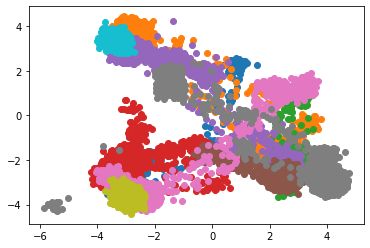

In [46]:
# Plot all locations to see concentration
import matplotlib.pyplot as plt
for i in range(0,12):
    if i != 7 and i != 11:
# i = 5
        plt.plot(traces_normalized[i][:,1], traces_normalized[i][:,2], 'o')
plt.show()

In [54]:
num_svr = 9
num_usr_loc = 9
# Generate visitng locations and server locations
usr_locs = gen_eq_locs(space_1d=10, nums=num_usr_loc,offset = 1)
svr_locs = gen_eq_locs(space_1d=10, nums=num_svr,offset = 1)

offset_x = 4.5
offset_y = 4.5
for i in range(len(usr_locs)):
    usr_locs[i] = (usr_locs[i][0]-offset_x, usr_locs[i][1]-offset_y)
for i in range(len(svr_locs)):
    svr_locs[i] = (svr_locs[i][0]-offset_x, svr_locs[i][1]-offset_y)


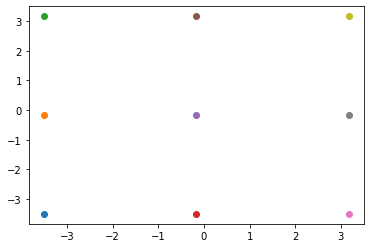

In [55]:
for i in range(len(usr_locs)):
    plt.plot(usr_locs[i][0],usr_locs[i][1], 'o')
plt.show()

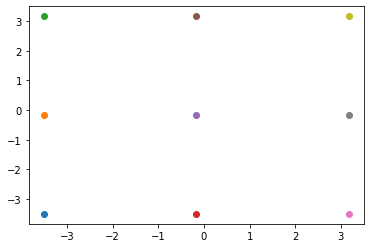

In [56]:
for i in range(len(svr_locs)):
    plt.plot(svr_locs[i][0],svr_locs[i][1], 'o')
plt.show()

In [76]:
traces_discretized = {}
for i in range(0,12):
    if i != 7 and i != 11:
#         T = goal
    #     load_trace = traces_normalized_repeated[i]
        load_trace = traces_normalized[i]
        closest = np.zeros(load_trace.shape[0])
        for t in range(load_trace.shape[0]):
            temp = np.zeros(num_usr_loc)
            x1 = load_trace[t,1]
            y1 = load_trace[t,2]
            for j in range(num_usr_loc):
                x2 = usr_locs[j][0]
                y2 = usr_locs[j][1]
                temp[j] = np.sqrt((x1-x2)**2 + (y1-y2)**2)
            closest[t] = np.random.choice(np.where(temp == temp.min())[0])
        traces_discretized[i] = closest

# combine all traces
# traces_discretized = np.empty(0)
# for i in range(0,12):
#     if i != 7+1 and i != 11+1:
# #         T = goal
#     #     load_trace = traces_normalized_repeated[i]
#         load_trace = traces_normalized[i]
#         closest = np.zeros(load_trace.shape[0])
#         for t in range(load_trace.shape[0]):
#             temp = np.zeros(num_usr_loc)
#             x1 = load_trace[t,1]
#             y1 = load_trace[t,2]
#             for j in range(num_usr_loc):
#                 x2 = usr_locs[j][0]
#                 y2 = usr_locs[j][1]
#                 temp[j] = np.sqrt((x1-x2)**2 + (y1-y2)**2)
#             closest[t] = np.random.choice(np.where(temp == temp.min())[0])
#         traces_discretized = np.append(traces_discretized, closest,axis=0)


In [77]:
traces_normalized

{0: array([[138.0, -3.1269659575610436, -3.319681362759108],
        [139.0, -3.2384901546003304, -3.024164630503248],
        [140.0, -3.3604731250377595, -3.036352416921128],
        ...,
        [149.0, -3.3654575257305335, -3.3422978991797603],
        [150.0, -3.0764774961234567, -3.367537395366581],
        [151.0, -3.1336673825322516, -3.08503443384552]], dtype=object),
 1: array([[115.0, -2.4283874917154105, 3.851191517778098],
        [116.0, -2.569577885275245, 3.905438823085157],
        [117.0, -2.441714510786701, 3.6446883116598947],
        ...,
        [153.0, -2.751683863759436, 3.756334801118157],
        [154.0, -2.635979540261296, 3.762490263246335],
        [155.0, -2.8504342758368946, 3.7902790165794817]], dtype=object),
 2: array([[179.0, 2.558565946045458, -2.6886487260130663],
        [180.0, 2.885956235615064, -2.173211810407282],
        [181.0, 2.9785446103548954, -2.203052852537839],
        ...,
        [286.0, 2.7989806890212425, -2.0278807129672343],
    

In [59]:
a = []
for i in range(num_usr_loc):
    a += [np.where(traces_discretized == i)[0].shape[0]]

In [60]:
traces_

[72028, 1165, 84011, 278, 1142, 2063, 88345, 2744, 41]

In [79]:
P_dict = {}
for i in range(0,12):
    if i != 7 and i != 11:
        P_temp = np.zeros([num_usr_loc,num_usr_loc])
        for t in range(traces_discretized[i].shape[0]-1):
            x = int(traces_discretized[i][t])
            y = int(traces_discretized[i][t+1])
            P_temp[x,y] += 1
        for j in range(num_usr_loc):
            P_temp[j] = P_temp[j]/(np.sum(P_temp[j]) + 0.0000001)
        # Fixing bad rows where movement doesn't occur to
        default_state = np.random.choice(np.where(np.sum(P_temp,axis=0) > 0.5)[0])
        for j in range(num_usr_loc):
            if np.sum(P_temp[j]) < 0.5 :
                P_temp[j,default_state] = 1
        P_dict[i] = P_temp

# P_temp = np.zeros([num_usr_loc,num_usr_loc])
# for t in range(traces_discretized.shape[0]-1):
#     x = int(traces_discretized[t])
#     y = int(traces_discretized[t+1])
#     P_temp[x,y] += 1
# for j in range(num_usr_loc):
#     P_temp[j] = P_temp[j]/(np.sum(P_temp[j]) + 0.0000001)
# # Fixing bad rows where movement doesn't occur to
# default_state = np.random.choice(np.where(np.sum(P_temp,axis=0) > 0.5)[0])
# for j in range(num_usr_loc):
#     if np.sum(P_temp[j]) < 0.5 :
#         P_temp[j,default_state] = 1

In [80]:
P_temp

array([[0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0.]])

In [65]:
with open("traces_P_40k.pkl", "wb") as tf:
    pickle.dump(P_temp,tf)

In [81]:
with open("traces_P_40k_dict.pkl", "wb") as tf:
    pickle.dump(P_dict,tf)

In [66]:
with open("traces_discretized_40k.pkl", "wb") as tf:
    pickle.dump(traces_discretized,tf)

In [67]:
default_state = np.random.choice(np.where(np.sum(P_temp,axis=0) > 0.5)[0])

In [68]:
default_state

2

In [69]:
traces_discretized[10000:11000]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.